## Carregamento de bibliotecas



In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Leitura do conjunto de dados

In [24]:
# Verificar se os arquivos existem
data_dir = '../data'
files = [f'loja_{i}.csv' for i in range(1, 5)]
for file in files:
    if not os.path.exists(os.path.join(data_dir, file)):
        raise FileNotFoundError(f"Arquivo {file} não encontrado!")

# Carregar dados com tratamento de erros
lojas = []
try:
    for i in range(1, 5):
        df = pd.read_csv(f'../data/loja_{i}.csv')
        df['Loja'] = f'Loja {i}'
        lojas.append(df)
    df = pd.concat(lojas, ignore_index=True)
except Exception as e:
    print(f"Erro ao carregar dados: {e}")
    raise

In [25]:
df.head()

,Produto,Categoria do Produto,Preço,Frete,Data da Compra,Vendedor,Local da compra,Avaliação da compra,Tipo de pagamento,Quantidade de parcelas,lat,lon,Loja
0,Assistente virtual,eletronicos,219.08,9.249790,16/01/2021,Pedro Gomes,SP,4,cartao_credito,8,-22.19,-48.79,Loja 1
1,Mesa de jantar,moveis,256.35,11.234305,18/05/2022,Beatriz Moraes,RJ,1,cartao_credito,4,-22.25,-42.66,Loja 1
2,Jogo de tabuleiro,brinquedos,279.51,21.262681,15/03/2021,João Souza,DF,1,cartao_credito,1,-15.83,-47.86,Loja 1
3,Micro-ondas,eletrodomesticos,1009.99,54.667344,03/05/2022,João Souza,RS,4,boleto,1,-30.17,-53.50,Loja 1
4,Cadeira de escritório,moveis,446.99,26.964689,07/11/2020,Larissa Alves,MG,5,boleto,1,-18.10,-44.38,Loja 1


# 1. Análise do Faturamento


In [26]:
# Calcular faturamento total
# Calcular faturamento formatando como moeda
faturamento = {
    loja: df[df['Loja'] == loja]['Preço'].sum() 
    for loja in df['Loja'].unique()
}
faturamento

{'Loja 1': 1534509.12,
 'Loja 2': 1488459.06,
 'Loja 3': 1464025.03,
 'Loja 4': 1384497.58}

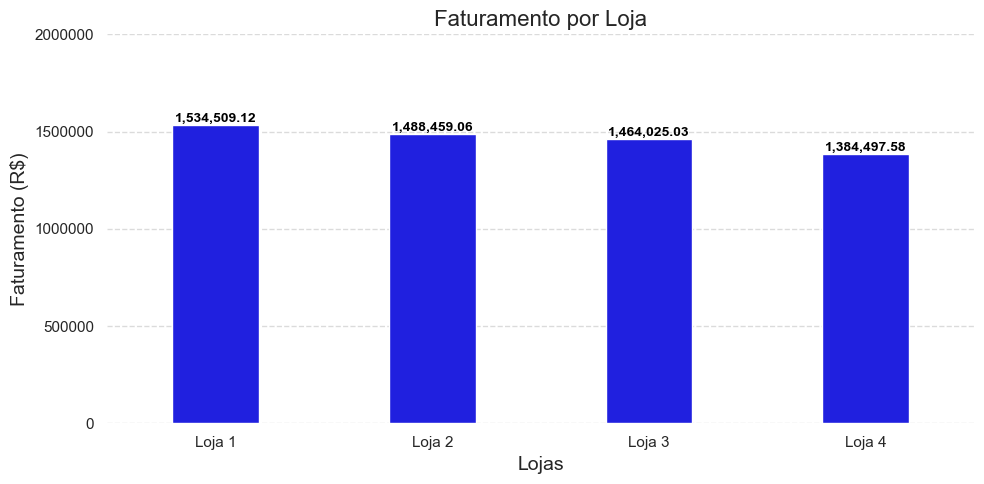

In [27]:
# Configurar o estilo do Seaborn
sns.set_theme(style="whitegrid")

# Criar o gráfico de barras
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=list(faturamento.keys()), y=list(faturamento.values()), color="blue", width=0.4)

# Adicionar os valores fora das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.2f}',  # Formatar com duas casas decimais
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Posição do texto
                ha='center', va='bottom', fontsize=10, color='black', weight='bold')  # Estilo do texto

# Ajustar os valores do eixo y
ax.set_yticks(range(0, int(max(faturamento.values())) + 500000, 500000))  # Intervalo de 500.000
ax.set_ylim(0, 2000000)  # Limite superior ajustado
ax.ticklabel_format(style='plain', axis='y', useOffset=False)

for spine in ax.spines.values():
    spine.set_visible(False)

# Configurações de título e eixos
plt.title('Faturamento por Loja', fontsize=16)
plt.xlabel('Lojas', fontsize=14)
plt.ylabel('Faturamento (R$)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar o gráfico
plt.tight_layout()
plt.show()


---
A Loja 1 lidera em faturamento, seguida pela Loja 2.

---


# 2. Vendas por Categoria


In [28]:
# Processar categorias
dados_categorias = []

for loja in df['Loja'].unique():
    # Filtrar apenas os dados da loja atual
    dados_loja = df[df['Loja'] == loja]
    nome_loja = loja  # Nome da loja atual
    categorias = dados_loja.groupby('Categoria do Produto')['Preço'].count().reset_index()
    categorias.columns = ['Categoria', 'Quantidade']
    categorias['Loja'] = nome_loja
    dados_categorias.append(categorias)

# Concatenar todos os dados em um único DataFrame
dados_consolidados = pd.concat(dados_categorias)


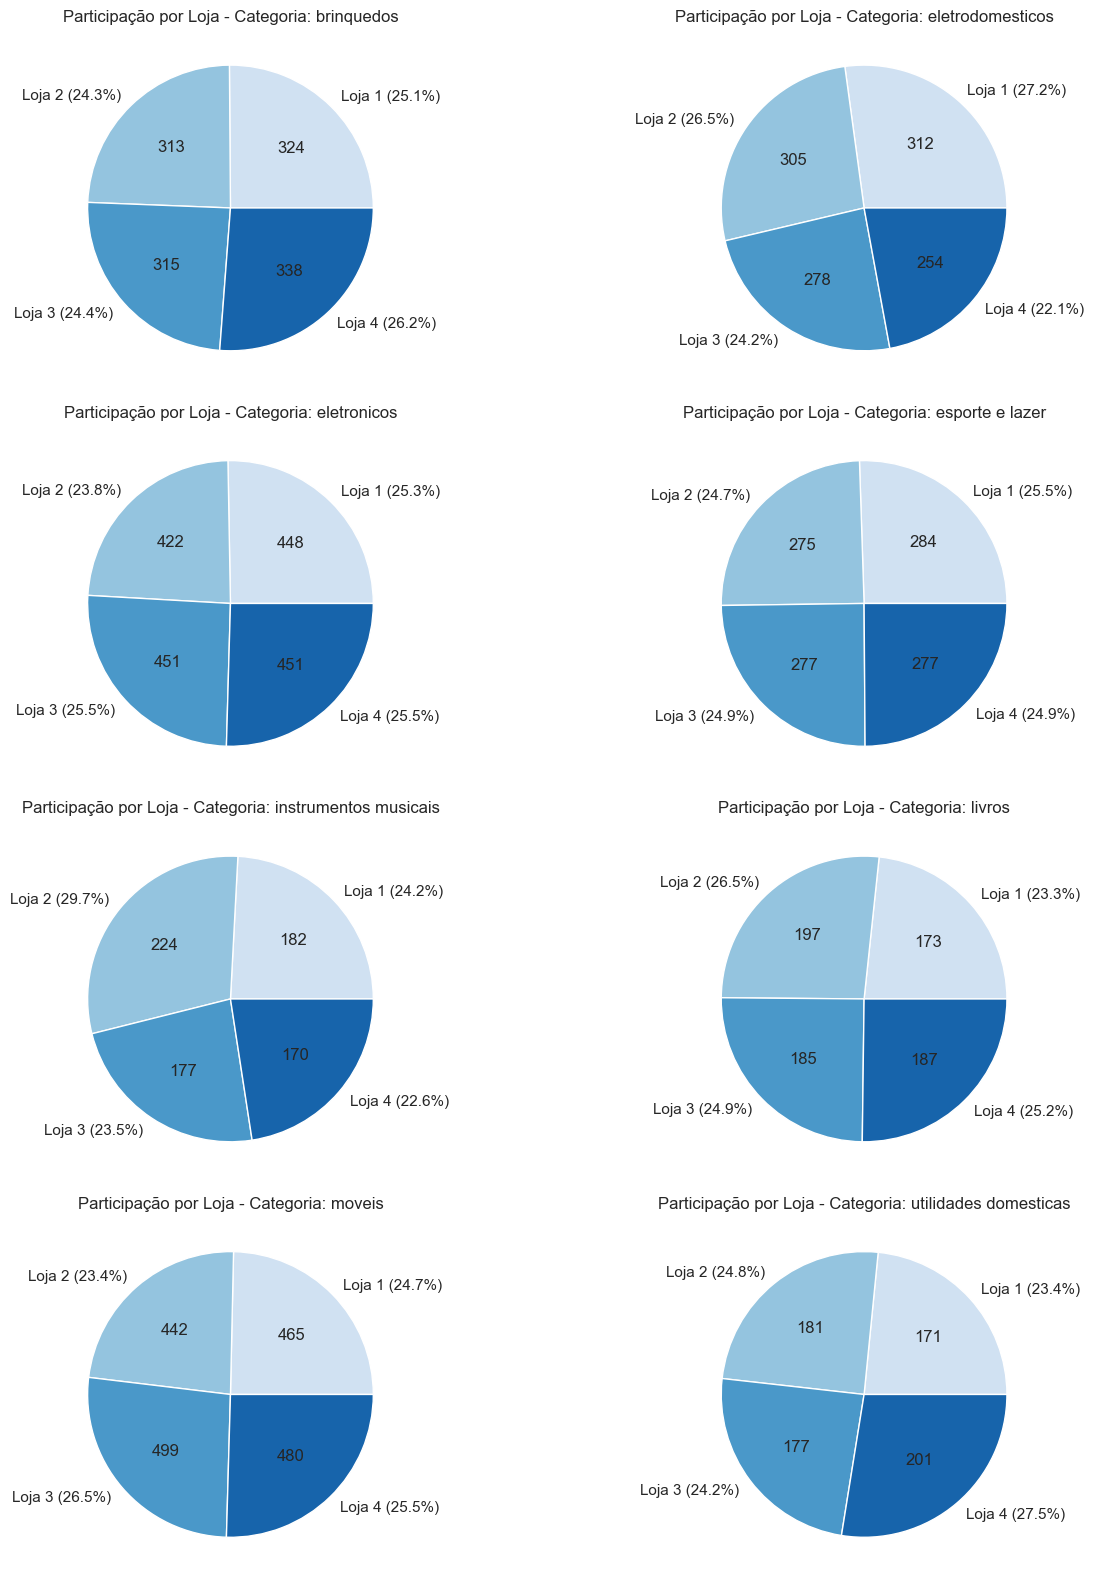

In [29]:
# Calcular o total por categoria
dados_consolidados['Porcentagem'] = (dados_consolidados['Quantidade'] / 
                                     dados_consolidados.groupby('Categoria')['Quantidade'].transform('sum')) * 100

# Obter categorias únicas
categorias = dados_consolidados['Categoria'].unique()

# Número de linhas e colunas para os subplots
n_rows = int(np.ceil(len(categorias) / 2))  # Calcular o número de linhas com base nas categorias

# Criar os subplots com 2 colunas
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(14, n_rows * 4))  # Ajustar o tamanho da figura

# Iterar pelas categorias para criar cada gráfico de setores
for i, categoria in enumerate(categorias):
    # Filtrar dados da categoria
    categoria_dados = dados_consolidados[dados_consolidados['Categoria'] == categoria]
    
    # Valores e etiquetas
    valores = categoria_dados['Quantidade']
    etiquetas = categoria_dados['Loja']
    
    # Determinar o eixo correto baseado no índice
    row, col = divmod(i, 2)  # Dividir o índice para obter a linha e a coluna
    ax = axes[row, col] if n_rows > 1 else axes[col]  # Compatível com casos de uma linha
    
    # Gráfico de pizza
    wedges, texts, autotexts = ax.pie(valores, labels=etiquetas, autopct='',
                                      colors=sns.color_palette('Blues', n_colors=len(etiquetas)))
    
    # Adicionar os valores dentro das fatias
    for autotext, valor in zip(autotexts, valores):
        autotext.set_text(f'{valor}')  # Substituir por valor inteiro
    
    # Adicionar porcentagens fora das fatias
    for text, pct in zip(texts, valores / valores.sum() * 100):
        text.set_text(f'{text.get_text()} ({pct:.1f}%)')  # Exibir loja com porcentagem fora da fatia
    
    ax.set_title(f'Participação por Loja - Categoria: {categoria}', fontsize=12)

# Ajustar layout e remover subplots vazios
for j in range(len(categorias), n_rows * 2):  # Iterar sobre subplots extras
    fig.delaxes(axes.flatten()[j])  # Remover subplots não utilizados

# Melhorar o layout
plt.tight_layout()
plt.show()


---
Em quase todas as categorias, as porcentagens das lojas são relativamente equilibradas, indicando uma concorrência uniforme entre elas.

---

# 3. Média de Avaliação das Lojas

In [30]:
# Calcular média de avaliação
avaliacao = {
    loja: df[df['Loja'] == loja]['Avaliação da compra'].mean() 
    for loja in df['Loja'].unique()
}

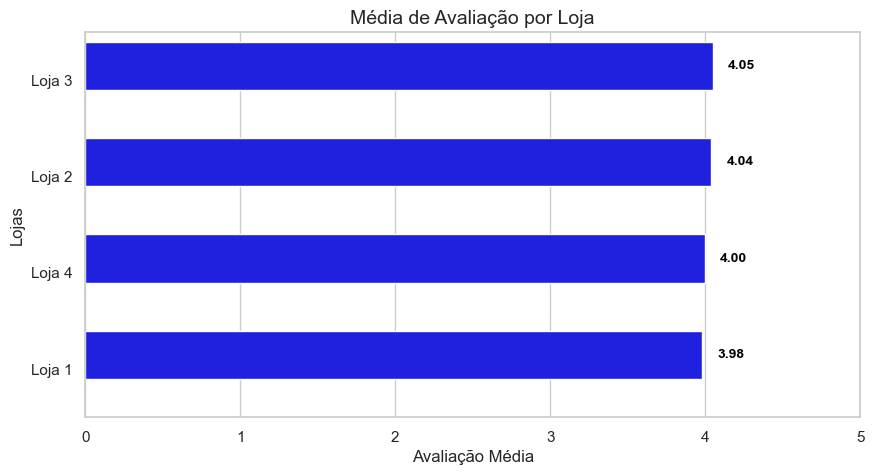

In [31]:
# Dados para avaliação (convertendo para DataFrame)
avaliacao_data = pd.DataFrame({
    'Loja': list(avaliacao.keys()),
    'Avaliação Média': list(avaliacao.values())
})

# Ordenar os dados em ordem decrescente
avaliacao_data = avaliacao_data.sort_values(by='Avaliação Média', ascending=False)

# Configurar o estilo do Seaborn
sns.set_theme(style="whitegrid")

# Gráfico de Barras Horizontais
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=avaliacao_data, y='Loja', x='Avaliação Média', color='blue', height=0.5)

# Adicionar os valores dentro das barras
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}',  # Texto com 2 casas decimais
                (p.get_width() + 0.1, p.get_y() + p.get_height() / 2.),  # Ajuste da posição do texto
                ha='left', va='center', color='black', fontsize=10, weight='bold')  # Estilo do texto

# Configurar título e rótulos
plt.title('Média de Avaliação por Loja', fontsize=14)
plt.xlabel('Avaliação Média', fontsize=12)
plt.ylabel('Lojas', fontsize=12)
plt.xlim(0, 5)  # Avaliação máxima é 5

# Mostrar o gráfico
plt.show()

---
Existe um equilíbrio nas médias da valiações, com uma leve vantagem para a Loja 3.

---


# 4. Produtos Mais e Menos Vendidos

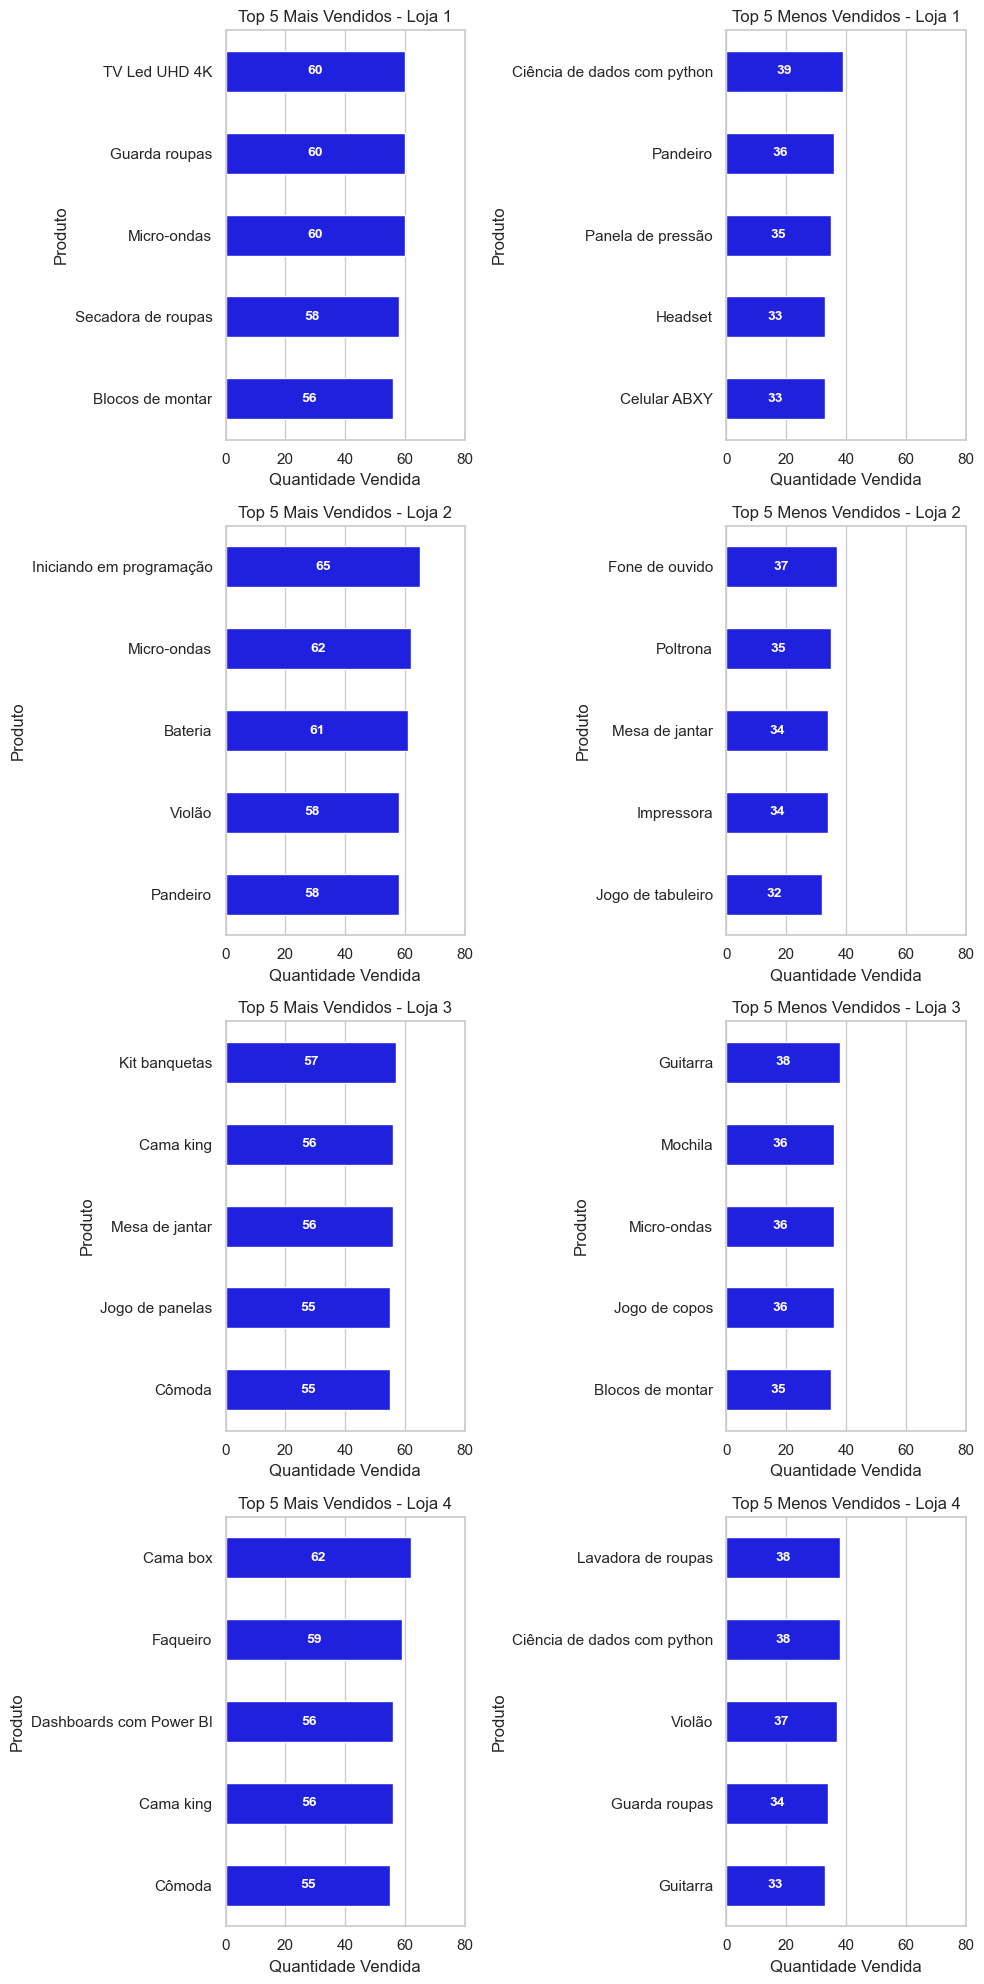

In [32]:
# Configurar o estilo do Seaborn
sns.set_theme(style="whitegrid")

# Criar figura com subplots
fig, axes = plt.subplots(nrows=len(lojas), ncols=2, figsize=(10, len(lojas) * 5))  # Subplots organizados por loja
fig.subplots_adjust(hspace=0.5)  # Ajustar espaço vertical entre os gráficos

# Loop pelas lojas para plotar os gráficos
for idx, df_loja in enumerate(lojas):  # Iterar diretamente pela lista
    nome_loja = df_loja['Loja'].iloc[0]  # Obter o nome da loja a partir da coluna "Loja"
    
    # Contar os produtos vendidos
    contagem_produtos = df_loja['Produto'].value_counts().reset_index()
    contagem_produtos.columns = ['Produto', 'Quantidade']

    
    # Selecionar os Top 5 mais vendidos
    top5_mais_vendidos = contagem_produtos.head(5)
    
    # Selecionar os Top 5 menos vendidos
    top5_menos_vendidos = contagem_produtos.tail(5)
    
    # Gráfico do Top 5 mais vendidos
    ax1 = sns.barplot(data=top5_mais_vendidos, x='Quantidade', y='Produto', color='blue', ax=axes[idx, 0], width=0.5)
    ax1.set_title(f'Top 5 Mais Vendidos - {nome_loja}', fontsize=12)
    ax1.set_xlabel('Quantidade Vendida', fontsize=12)
    ax1.set_ylabel('Produto', fontsize=12)
    ax1.set_xlim(0, 80)  # Configurar o limite do eixo x
    
    # Adicionar valores dentro das barras
    for p in ax1.patches:
        ax1.annotate(f'{int(p.get_width())}', 
                     (p.get_width() / 2., p.get_y() + p.get_height() / 2.),  # Centralizar na barra
                     ha='center', va='center', fontsize=10, color='white', weight='bold')

    # Gráfico do Top 5 menos vendidos
    ax2 = sns.barplot(data=top5_menos_vendidos, x='Quantidade', y='Produto', color='blue', ax=axes[idx, 1], width=0.5)
    ax2.set_title(f'Top 5 Menos Vendidos - {nome_loja}', fontsize=12)
    ax2.set_xlabel('Quantidade Vendida', fontsize=12)
    ax2.set_ylabel('Produto', fontsize=12)
    ax2.set_xlim(0, 80)  # Configurar o limite do eixo x
    
    # Adicionar valores dentro das barras
    for p in ax2.patches:
        ax2.annotate(f'{int(p.get_width())}', 
                     (p.get_width() / 2., p.get_y() + p.get_height() / 2.),  # Centralizar na barra
                     ha='center', va='center', fontsize=10, color='white', weight='bold')

# Exibir os gráficos
plt.tight_layout()
plt.show()

---
Cada loja tem um perfil de produto bem distinto:

- Loja 1: forte em eletrônicos (TV 4K, micro‑ondas) e grandes móveis (guarda‑roupas, secadora).

- Loja 2: misto de cursos de tecnologia (“Iniciando em programação”), eletrodomésticos e instrumentos musicais (bateria, violão, pandeiro).

- Loja 3: focada quase exclusivamente em móveis e itens para casa (kits de banquetas, cama king, mesa de jantar, cômoda).

- Loja 4: também móveis (cama box, cama king, cômoda), mas com forte apelo a itens de cozinha (faqueiro) e até produtos de formação (“Dashboards com Power BI”).

---

# 5. Frete Médio por Loja


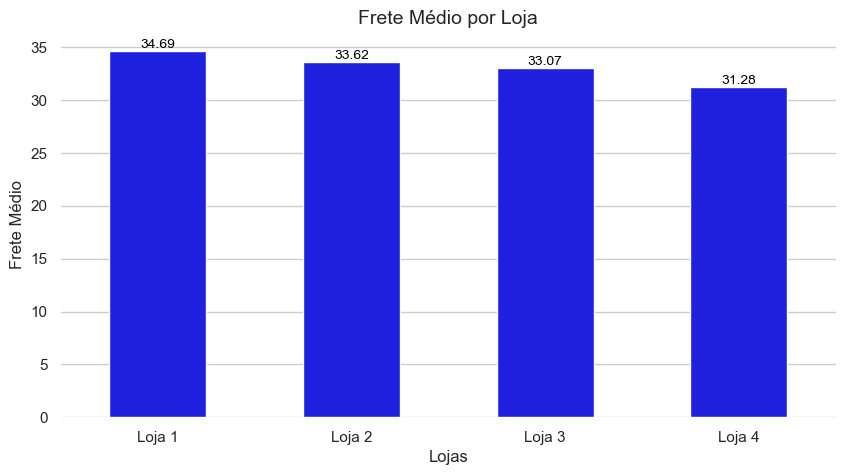

In [33]:
# Calcular o frete médio diretamente do DataFrame consolidado
frete_df = df.groupby('Loja')['Frete'].mean().reset_index()

# Configurar o tema do Seaborn
sns.set_theme(style="whitegrid")

# Criar o gráfico de barras
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=frete_df, x='Loja', y='Frete', color='blue', width=0.5)

for spine in ax.spines.values():
    spine.set_visible(False)

# Adicionar os valores sobre as barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

# Configurar título e rótulos
plt.title('Frete Médio por Loja', fontsize=14)
plt.xlabel('Lojas', fontsize=12)
plt.ylabel('Frete Médio', fontsize=12)

# Exibir o gráfico
plt.show()

---
A Loja 4 é a que tem o menor frete médio, seguido da loja 3.

---

# Conclusão
---
A Loja 4 é a que tem o menor faturamento (cerca de R$ 1,38 M), ou seja, gera menos receita do que qualquer outra. Além disso:

- Apresenta avaliação média de clientes ligeiramente inferior ao das demais.

- Tem custo de frete médio parecido ou até um pouco maior em relação ao que fatura, reduzindo sua “eficiência” de operação (menos receita gerada por real investido em frete).

- Nas análises de top/menos vendidos, seus principais itens (cama box, faqueiro) não alcançam nem de longe os picos de giro vistos em lojas especializadas (como móveis na Loja 3 ou cursos na Loja 2).

> Em conjunto, isso indica que a Loja 4 é a menos eficiente do ponto de vista de retorno sobre estoque, logística e satisfação do cliente.

---

# Recomendação

---
> O Senhor João deve vender a Loja 4 e reinvestir o capital em uma das outras unidades (por exemplo, Loja 1 ou Loja 2), que apresentam faturamento mais alto, melhores ratings e maior eficiência operacional. Dessa forma, ele maximiza o retorno do novo empreendimento com recursos mais bem aproveitados.

---